Loading word list!
Loaded the word list!
Loading word vectors!
Loaded the word vectors!
Going through Positive Files
Positive files finished
Going through Negative Files
Negative files finished
The total number of files is 25000
The total number of words in the files is 5713167
The average number of words in the files is 228.52668


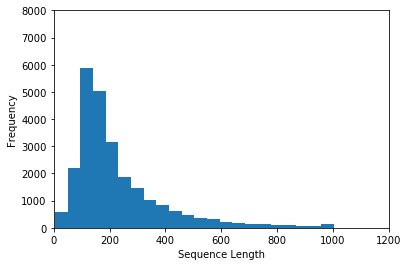

Going through Positive Files for indices
Positive files finished
Going through Negative Files for indices
Negative files finished
(25000, 250)
Making Input Data Matrix
Input Data Matrix Loaded
Positive files finished
(25000, 12500)


In [1]:
#########################
###Import Testing Data###
#########################

#For detailed comments read 
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import re
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

pwd='/Users/pulkit/Google Drive/Stan Courses/4. Fall 2017/CS229 ML/Project/CS229-Project/'
datapath=pwd+'stanford_test/'

print('Loading word list!')
wordsList = np.load(datapath+'wordsList-lexic-sorted.npy').tolist()
print('Loaded the word list!')

print('Loading word vectors!')
wordVectors = np.load(datapath+'wordVectors-lexic-sorted.npy')
print ('Loaded the word vectors!')

#Dimensionality of Word Vector in the word-to-vec dictionary
wordEncodingLen=50

positiveFiles = [datapath+'pos/' + f for f in listdir(datapath+'pos/') if isfile(join(datapath+'pos/', f))]
negativeFiles = [datapath+'neg/' + f for f in listdir(datapath+'neg/') if isfile(join(datapath+'neg/', f))]
numWords = []

print('Going through Positive Files')
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

print('Going through Negative Files')
for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

#define for string cleaning
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

#define for finding index in wordvec
def findIndex(search_list, begin, end, key):
    mid = int((end - begin + 1)/2) + begin
    if end == begin:
        if search_list[mid] == key:
            return mid
        else:
            return -1
    if end == begin + 1:
        if search_list[begin] == key:
            return begin
        if search_list[end] == key:
            return end
        else:
            return -1
    if search_list[mid] < key:
        return findIndex(search_list, mid, end, key)
    return findIndex(search_list, begin, mid, key)

maxSeqLength=250

ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
print('Going through Positive Files for indices')
for pf in positiveFiles:
    with open(pf, "r") as f:
        indexCounter = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            try:
                ids[fileCounter][indexCounter] = findIndex(wordsList, 0, len(wordsList)-1, word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unknown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        fileCounter = fileCounter + 1 
print('Positive files finished')

print('Going through Negative Files for indices')
for nf in negativeFiles:
    with open(nf, "r") as f:
        indexCounter = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            try:
                ids[fileCounter][indexCounter] = findIndex(wordsList, 0, len(wordsList)-1, word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unknown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        fileCounter = fileCounter + 1 
 #Pass into embedding function and see if it evaluates. 
print('Negative files finished')

print(ids.shape)


labels=-1*np.ones(numFiles)
labels[0:int(numFiles/2)]=np.ones(int(numFiles/2))

#print(np.unique(labels))
print('Making Input Data Matrix')

#Choose feature type:
#'allVectors': as all vectors implying each example is 12500 dimensional
#'meanVectors': as all vectors implying each example is 50 dimensional

featureType='allVectors'

if featureType=='allVectors':
    inputData=np.zeros((numFiles,maxSeqLength*wordEncodingLen))
    for i in range(numFiles):
            for j in range(maxSeqLength):
                    inputData[i,j*wordEncodingLen:(j+1)*wordEncodingLen]=wordVectors[ids[i,j],]
elif featureType=='meanVectors':
    inputData=np.zeros((numFiles,wordEncodingLen))
    for i in range(numFiles):
        inputData[i,0:wordEncodingLen]=np.mean(wordVectors[ids[i,:],],axis=0)
print('Input Data Matrix Loaded')

print('Positive files finished')
print((inputData.shape))

X_test=inputData
y_test=labels

In [3]:


# Load Model, kernel and Predict
label="linear_with_n12500.txt"
kernel='linear'

svm_model = joblib.load(label) 

print(svm_model)
# Make appropriate features

print('Computing Feature Set')
if kernel=='linear':
    X_test_newFeatures=X_test
elif kernel=='poly2':
    poly = PolynomialFeatures(degree=2)
    X_test_newFeatures=poly.fit_transform(X_test.toarray())
elif kernel=='poly3':
    poly = PolynomialFeatures(degree=3)
    X_test_newFeatures=poly.fit_transform(X_test.toarray())
elif kernel=='RBF':
    rbf_feature = RBFSampler(gamma=1, random_state=1)#, n_components=25000)
    X_test_newFeatures = rbf_feature.fit_transform(X_test)
print('Feature Set Computed')

print('Predicting')
y_model=svm_model.predict(X_test_newFeatures)
print(y_model.shape)

#print(np.unique(y_model))

misclassifiedFraction=(np.sum(np.fabs(y_model-y_test)))/(2*y_test.size)
print('Misclassified Fraciton on Test Dataset='+str(misclassifiedFraction))
confusion_matrix(y_test,y_model)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10000000.0,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=1e-05, verbose=0, warm_start=False)
Computing Feature Set
Feature Set Computed
Predicting
(25000,)
Misclassified Fraciton on Test Dataset=0.34012


array([[8202, 4298],
       [4205, 8295]])